In [1]:
import os, warnings
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

ds_train = image_dataset_from_directory(
    '/home/hub/Documents/Disciplina IA/Classification Cats-Dogs/train',
    labels='inferred',
    label_mode = 'binary',
    interpolation='nearest',
    image_size = [64,64],
    batch_size=64,
    shuffle =True
)

ds_valid = image_dataset_from_directory(
    '/home/hub/Documents/Disciplina IA/Classification Cats-Dogs/test',
    labels='inferred',
    label_mode = 'binary',
    interpolation='nearest',
    image_size = [64,64],
    batch_size=64,
    shuffle =True    
)

def convert_to_float(image,label):
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    return image,label

AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_train = (
    ds_train.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)
)

ds_valid = (
    ds_valid.map(convert_to_float).cache().prefetch(buffer_size = AUTOTUNE)
)

2023-11-14 14:22:54.198092: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 14:22:54.201056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 14:22:54.243016: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 14:22:54.243832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 14:22:55.048726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Found 557 files belonging to 2 classes.
Found 140 files belonging to 2 classes.


In [2]:
# pretrained_base = tf.keras.models.load_model(
#     tf.keras.applications.VGG16()
# )
# pretrained_base.trainable = False

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

modelo = Sequential()
modelo.add(Conv2D(32, (5,5), activation='relu', input_shape=(64, 64, 3)))
modelo.add(Conv2D(64, (5,5), activation='relu'))
modelo.add(Conv2D(128, (5,5), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(3,3)))

modelo.add(Flatten())
modelo.add(Dense(128, activation='relu'))
modelo.add(Dropout(0.3))
modelo.add(Dense(1, activation='sigmoid'))

# model = keras.Sequential([
#     pretrained_base,
#     layers.Flatten(),
#     layers.Dense(6, activation='relu')
#     layers.Dense(1, activation='sigmoid')
# ])

modelo.summary()

modelo.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics = ['binary_accuracy']
)

history = modelo.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 10,
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       204928    
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 17, 128)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 36992)             0         
                                                                 
 dense (Dense)               (None, 128)               4735104   
                                                        

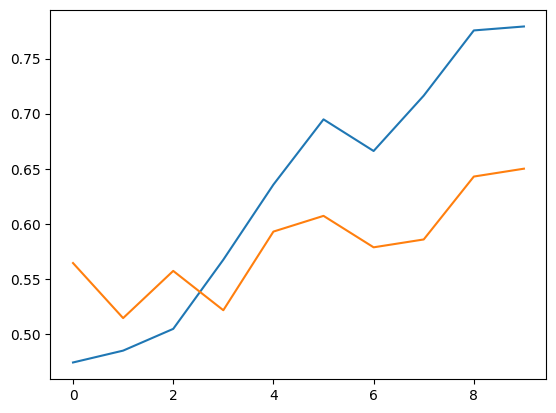

In [4]:
import matplotlib.pyplot as plt

# Gráfico para visualizar os erros e accuracy
history.history.keys()
#evolução do erro, azul
plt.plot(history.history['binary_accuracy'])
#performance da rede
plt.plot(history.history['val_binary_accuracy'])

In [5]:
test_loss, test_acc = modelo.evaluate(ds_valid, verbose=1)

3/3 [==============================] - 1s 232ms/step - loss: 0.7205 - binary_accuracy: 0.6500


In [6]:
print(f'Acurácia: {test_acc} - Erro: {test_loss}')

Acurácia: 0.6499999761581421 - Erro: 0.7204611897468567
